# architecture-11 ( Basic Regression Wide And Deep Add TA-Lib )
What's new:

1- Convert the LSTM to Multi-Head Attention.

## Conclusion

Your model architecture is:

* Well-designed

* Efficient

* Performs well

* Implements best practices for attention-based time series forecasting

With a final test MAE ~0.0088 (in normalized scale), you’re already at a level suitable for real-world deployment and live testing. Further improvements would be experimentation-based, not corrections.

*************************************************************
## architecture-05 vs architecture-11
### Expert Take

From a machine learning and finance perspective:

* Your architecture-11 is a well-designed architecture and matches modern forecasting standards (MHA, wide inputs, residuals).

* But its extra complexity is not justified unless you are solving a harder or broader problem than simple directional price prediction.

* For now, architecture-05 gives ~95% of the benefit with 10% of the cost.

### 📌 Conclusion:

✅ Stick with architecture-05 for now, especially if you're iterating fast or testing new ideas.

🔁 Keep architecture-11 ready for future use — e.g., in multi-market scenarios, regime adaptation, or if architecture-05 fails to scale.

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, Concatenate, GlobalAveragePooling1D, LayerNormalization, MultiHeadAttention,Dropout, Add
from tensorflow.keras.models import Model
import talib

In [3]:
# === Load and preprocess ===
df = pd.read_csv('datasets-11/XAGUSD-H1-rates.csv', sep='\t')

In [4]:
def add_ta_features(df):
    df['rsi'] = talib.RSI(df['<CLOSE>'], timeperiod=14)
    df['macd'], _, df['MACD_hist'] = talib.MACD(df['<CLOSE>'])
    df['ema_50'] = talib.EMA(df['<CLOSE>'], timeperiod=50)
    df['atr'] = talib.ATR(df['<HIGH>'], df['<LOW>'], df['<CLOSE>'], timeperiod=14)
    df['adx'] = talib.ADX(df['<HIGH>'], df['<LOW>'], df['<CLOSE>'], timeperiod=14)
    return df.dropna()


df = add_ta_features(df)

In [5]:
# === Feature selection and scaling ===
sequence_features = ['<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>', '<TICKVOL>']
wide_features = ['<SPREAD>', '<VOL>', 'adx', 'atr', 'ema_50', 'macd', 'MACD_hist', 'rsi']

scaler_seq = MinMaxScaler()
scaler_wide = MinMaxScaler()
scaler_close = MinMaxScaler()

scaled_seq = scaler_seq.fit_transform(df[sequence_features])
scaled_wide = scaler_wide.fit_transform(df[wide_features])
scaled_close = scaler_close.fit_transform(df[['<CLOSE>']])  # Target values

# === Create sequences for time series prediction ===
def create_sequences(seq_data, wide_data, target_data, window, horizon):
    X_seq, X_wide, y = [], [], []
    for i in range(window, len(seq_data) - horizon):
        X_seq.append(seq_data[i-window:i])
        X_wide.append(wide_data[i-1])  # use last row of each window
        y.append(target_data[i:i+horizon].flatten())
    return np.array(X_seq), np.array(X_wide), np.array(y)

WINDOW_SIZE = 60
FORECAST_HORIZON = 10

X_seq, X_wide, y = create_sequences(scaled_seq, scaled_wide, scaled_close, WINDOW_SIZE, FORECAST_HORIZON)

# === Train/Test split ===
X_seq_train, X_seq_test, X_wide_train, X_wide_test, y_train, y_test = train_test_split(
    X_seq, X_wide, y, test_size=0.2, shuffle=False
)

# === Build Wide & Deep model with Multi-Head Attention ===
def build_wide_deep_model_with_mha(seq_shape, wide_shape, horizon, num_heads=4, ff_dim=64, dropout_rate=0.1):
    # === Sequence input (Deep part) ===
    seq_input = Input(shape=seq_shape, name="sequence_input")

    # Multi-Head Self-Attention
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=seq_shape[-1], name="mha_layer")(seq_input, seq_input)
    attention_output = Dropout(dropout_rate, name="mha_dropout")(attention_output)
    attention_output = Add(name="mha_residual_add")([seq_input, attention_output])
    attention_output = LayerNormalization(name="mha_layer_norm")(attention_output)

    # Feed-Forward Network block
    ffn_dense = Dense(ff_dim, activation='relu', name='ffn_dense_1')(attention_output)
    ffn_dropout = Dropout(dropout_rate, name='ffn_dropout')(ffn_dense)

    # Project residual path to match shape
    ffn_projection = Dense(ff_dim, name='ffn_projection')(attention_output)

    # Residual connection after FFN
    ffn_output = Add(name='ffn_residual_add')([ffn_projection, ffn_dropout])
    ffn_output = LayerNormalization(name='ffn_layer_norm')(ffn_output)

    # Global Average Pooling
    seq_output = GlobalAveragePooling1D(name="sequence_global_avg_pool")(ffn_output)

    # === Wide input ===
    wide_input = Input(shape=wide_shape, name="wide_input")

    # === Combine Wide and Deep parts ===
    combined = Concatenate(name="concat_wide_deep")([seq_output, wide_input])
    x = Dense(64, activation='relu', name='combined_dense_1')(combined)
    x = Dense(32, activation='relu', name='combined_dense_2')(x)
    output = Dense(horizon, name='forecast_output')(x)

    # === Build and compile model ===
    model = Model(inputs=[seq_input, wide_input], outputs=output, name="WideDeepMHA")
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model


# === Initialize model ===
model = build_wide_deep_model_with_mha(
    seq_shape=(X_seq_train.shape[1], X_seq_train.shape[2]),
    wide_shape=(X_wide_train.shape[1],),
    horizon=FORECAST_HORIZON
)



I0000 00:00:1751793356.837481   14928 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2395 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5


In [6]:
# === Train model with early stopping ===
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    [X_seq_train, X_wide_train],
    y_train,
    validation_split=0.2,
    epochs=50,
    callbacks=[es],
    verbose=1
)

Epoch 1/50


I0000 00:00:1751793366.897704   14994 service.cc:148] XLA service 0x7ec6ec006490 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751793366.897722   14994 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 SUPER, Compute Capability 7.5
2025-07-06 12:46:06.956307: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1751793367.234902   14994 cuda_dnn.cc:529] Loaded cuDNN version 91001


  62/1100 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1054 - mae: 0.2138

2025-07-06 12:46:10.242813: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_fusion', 48 bytes spill stores, 48 bytes spill loads

I0000 00:00:1751793370.262123   14994 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1100/1100 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 0.0163 - mae: 0.0610 - val_loss: 8.9024e-04 - val_mae: 0.0245
Epoch 2/50
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.0935e-04 - mae: 0.0147 - val_loss: 8.1591e-04 - val_mae: 0.0241
Epoch 3/50
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 2.7699e-04 - mae: 0.0119 - val_loss: 0.0014 - val_mae: 0.0335
Epoch 4/50
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 2.0711e-04 - mae: 0.0104 - val_loss: 0.0011 - val_mae: 0.0290
Epoch 5/50
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.8078e-04 - mae: 0.0095 - val_loss: 4.6127e-04 - val_mae: 0.0172
Epoch 6/50
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.7797e-04 - mae: 0.0093 - val_loss: 0.0015 - val_mae: 0.0360
Epoch 7/50
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.4839e-04 - mae: 0.0085 - val_loss: 5.2871e-04 - val_mae: 0.0191
Epoch 8/50
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.3481e-04 - mae: 0.0080 - val_loss: 0.0019 - val_mae: 0.0411
Epoch 

In [7]:
# === Load the last 110 rows from a separate CSV file for prediction ===
# These rows represent recent unseen data (e.g., from a live market feed or a new test set).
input_df = pd.read_csv('datasets-11/new-data-for-test/rows-60-from-20240503/rows-110-from-20240503.csv', sep='\t')

# Add technical indicators using the same preprocessing function used during training
input_df = add_ta_features(input_df)

# Take only the last 60 usable rows after TA features
input_df = input_df.tail(60)

# Apply the same scalers used during training to ensure consistency
input_seq_scaled = scaler_seq.transform(input_df[sequence_features])
input_wide_scaled = scaler_wide.transform(input_df[wide_features])

# Reshape the sequence input to shape (1, 60, num_features) for prediction
input_seq = np.expand_dims(input_seq_scaled, axis=0)
# Use only the last row of wide features to match model input requirements
input_wide = np.expand_dims(input_wide_scaled[-1], axis=0)


pred = model.predict([input_seq, input_wide])
prediction = scaler_close.inverse_transform(pred)
print("Next 10 predicted closing prices:", prediction.flatten())

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step
Next 10 predicted closing prices: [27.930042 28.113361 27.980354 28.396358 27.646544 28.179398 28.115595
 27.749605 28.003918 28.282331]


# plot section

In [8]:
import sys

sys.path.insert(1, '../utils')
import forex_plot_utils
import os

# PARAMETERS
csv1_path = 'datasets-11/new-data-for-test/rows-60-from-20240503/latest-4-for-history.csv'
csv3_path = 'datasets-11/new-data-for-test/rows-60-from-20240503/after.csv'
plot_title = 'Actual vs Predicted Forex Closing Prices'
output_plot_path = None  # e.g., 'output.png'

# LOAD DATA FROM CSVS
historical_df = forex_plot_utils.load_csv_with_datetime(csv1_path) if os.path.exists(csv1_path) else None
actual_future_df = forex_plot_utils.load_csv_with_datetime(csv3_path) if os.path.exists(csv3_path) else None

# LOAD DATA FROM PREDICTION

# Combine <DATE> and <TIME> columns into a datetime
input_df['DATETIME'] = pd.to_datetime(input_df['<DATE>'] + ' ' + input_df['<TIME>'])

last_timestamp = input_df['DATETIME'].iloc[-1]
datetime_index = pd.date_range(start=last_timestamp + pd.Timedelta(hours=1), periods=len(prediction[0]), freq='h')

# Create DataFrame
predicted_df = pd.DataFrame({'DATETIME': datetime_index, '<CLOSE>': prediction[0]})

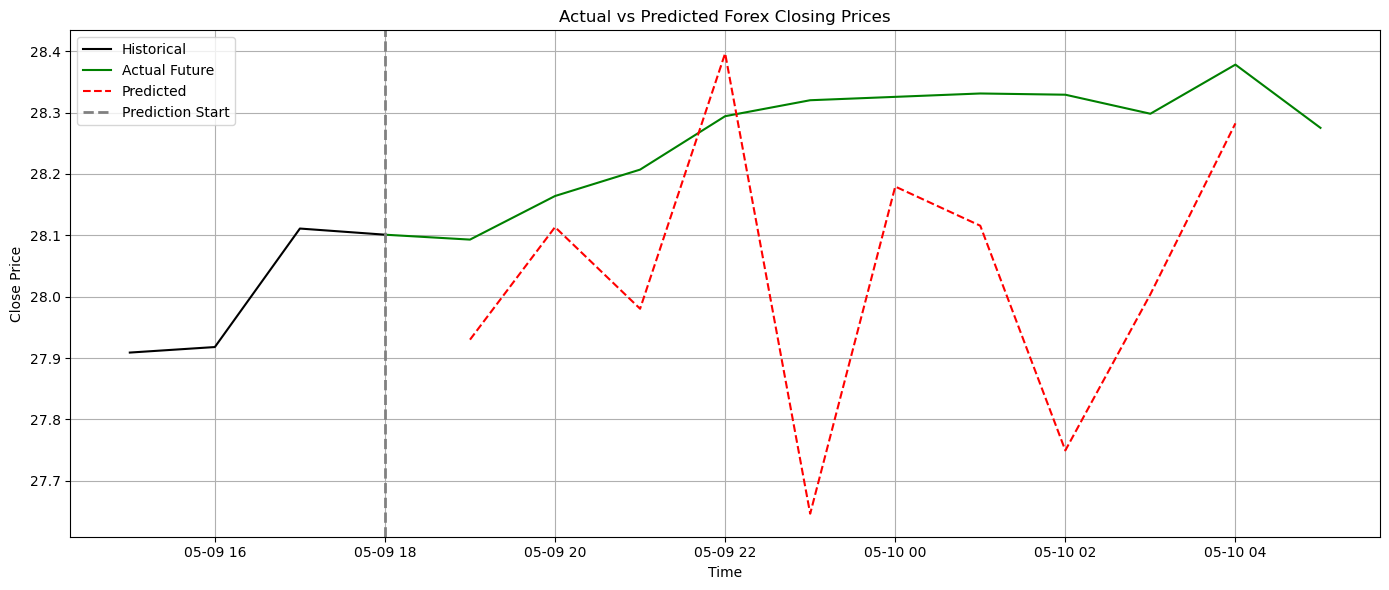

In [9]:
# PLOT
forex_plot_utils.plot_all_series(
    historical_df=historical_df,
    predicted_df=predicted_df,
    actual_future_df=actual_future_df,
    title=plot_title,
    output_path=output_plot_path
)

In [10]:
from datetime import datetime
import os
import pandas as pd
import matplotlib.pyplot as plt

# === Create timestamp and paths ===
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_filename = f'model_{timestamp}.keras'
model_path = os.path.join('saved_models', model_filename)

# Directory to hold logs and extras
log_dir = os.path.join('saved_models', f'model_{timestamp}_logs')
os.makedirs(log_dir, exist_ok=True)

# === Save model ===
model.save(model_path)

# === Save training history ===
history_df = pd.DataFrame(history.history)
history_df.to_csv(os.path.join(log_dir, 'training_history.csv'), index=False)

# === Save training loss plot ===
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(log_dir, 'training_loss.png'))
plt.close()

# === Save model summary and final performance ===
with open(os.path.join(log_dir, 'model_log.txt'), 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))
    final_train_loss = history.history['loss'][-1]
    final_test_loss, final_test_mae = model.evaluate([X_seq_test, X_wide_test], y_test, verbose=0)
    f.write(f'\nFinal Training Loss: {final_train_loss:.6f}\n')
    f.write(f'Final Test Loss : {final_test_loss:.6f}\n')
    f.write(f'Final Test MAE : {final_test_mae:.6f}\n')
